In [34]:
#  Section 1: Imports and Setup
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from pyswarm import pso
from dotenv import load_dotenv
from openai import OpenAI

#  Section 2: Load API Key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#  Section 3: Load and Prepare Dataset
df = pd.read_excel("default of credit card clients.xls", header=1)
X = df.drop(columns=["ID", "default payment next month"]).values
y = df["default payment next month"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#  Section 4: Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)
        


\n[Iter 1] Running PSO with w=0.5, c1=1.0, c2=1.0
Best AUC this iteration: 0.6925

===== GPT Prompt (Iter 1) =====
You are helping tune PSO meta-parameters. This is iteration 1.

Here are the top performing particles (MLP hyperparameters and AUC scores):
#1: hidden=102, lr=0.00787, dropout=0.18, l2=0.00515, AUC=0.6925
#2: hidden=87, lr=0.00951, dropout=0.39, l2=0.00599, AUC=0.6840
#3: hidden=128, lr=0.00711, dropout=0.11, l2=0.00970, AUC=0.6838
#4: hidden=169, lr=0.00220, dropout=0.17, l2=0.00184, AUC=0.6533
#5: hidden=74, lr=0.00530, dropout=0.27, l2=0.00292, AUC=0.6509

Based on these results, recommend the following PSO meta-parameters:
- inertia_weight (float between 0.1 and 1.2)
- cognitive_coeff (float between 0.5 and 2.5)
- social_coeff (float between 0.5 and 2.5)

Please also provide a short reasoning.

Respond ONLY in this JSON format:
{
  "inertia_weight": float,
  "cognitive_coeff": float,
  "social_coeff": float,
  "reason": "..."
}


===== GPT Response (Iter 1) =====
{
  "

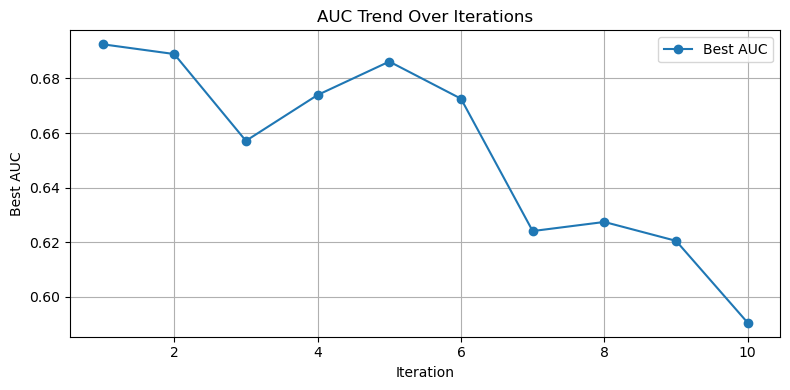

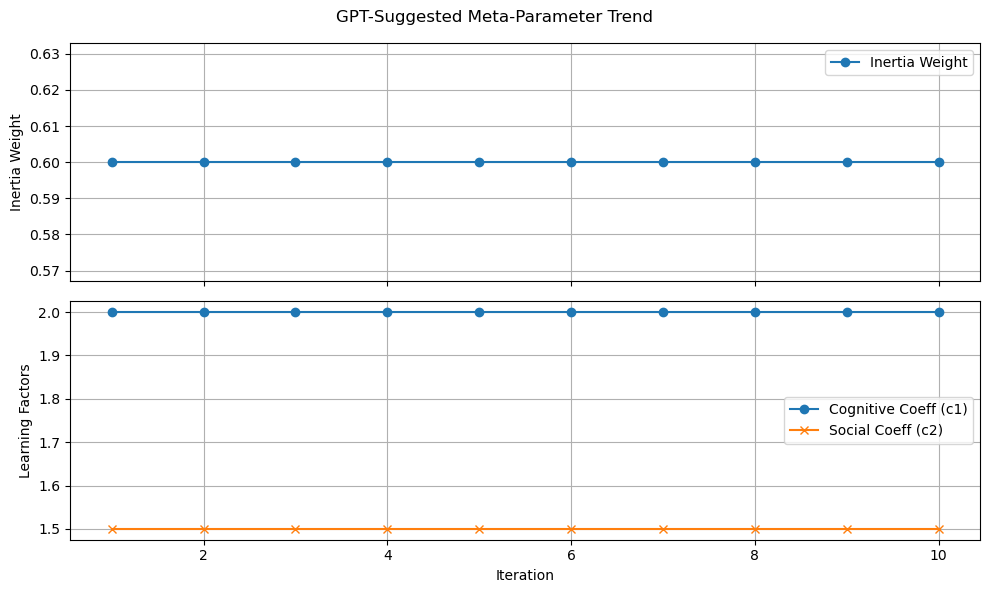

In [47]:
from gpt_pso_framework.utils import generate_fixed_particles
from gpt_pso_framework.runner import run_dynamic_pso_loop
from gpt_pso_framework.visualize import plot_auc_trend, plot_meta_param_trend



param_bounds = [
    (20, 200),        # hidden
    (0.0001, 0.01),   # lr
    (0.1, 0.5),       # dropout
    (1e-5, 0.01)      # L2
]

init_particles = generate_fixed_particles(swarmsize=10, param_bounds=param_bounds)

def my_eval_fn(params):
    hidden = int(params[0])
    lr = params[1]
    dropout = params[2]
    l2 = params[3]

    model = MLP(input_dim=23, hidden_dim=hidden, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

    for epoch in range(10): 
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_val), dim=1)[:, 1].numpy()
        auc_score = roc_auc_score(y_val.numpy(), probs)

    return auc_score

all_results, meta_history, best_result = run_dynamic_pso_loop(
    initial_particles=init_particles,
    param_bounds=param_bounds,
    eval_fn=my_eval_fn,
    max_iter=10
)


plot_auc_trend(meta_history)
plot_meta_param_trend(meta_history)

import pandas as pd

df = pd.DataFrame(meta_history)
df.to_csv("meta_history.csv", index=False)


In [49]:
from gpt_pso_framework.visualize import plot_auc_comparison

plot_auc_comparison(gpt_results=all_results, fixed_results=fixed_results)


ImportError: cannot import name 'plot_auc_comparison' from 'gpt_pso_framework.visualize' (C:\Users\aoshin\Desktop\5703\W7\gpt_pso_framework\visualize.py)